this notebook partially reproduces Figure 6 of the 2010 paper.

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy.io import loadmat

from torchvision.utils import make_grid
from torch import FloatTensor

from pc_v1 import dir_dictionary
from pc_v1 import io, core

In [3]:
# first, show all the filters.
w_ff_on, w_ff_off = io.dim_conv_v1_filter_definitions()

In [4]:
# adapted from <https://github.com/leelabcnbc/cnn-v1-jcns2018/blob/master/fig7_cnn.ipynb>
def imshow_pytorch(npimg, figsize=(8, 6), title=None):
    plt.close('all')
    plt.figure(figsize=figsize)
    img_to_show = np.transpose(npimg.numpy(), (1, 2, 0))
    plt.imshow(img_to_show)
    plt.axis('off')
    if title is not None:
        plt.title(title)

    plt.show()

In [5]:
def plot_groups_of_lines(xdata, data, names, style, *, ax=None, xlog=False):
    if ax is None:
        ax = plt.gca()
    assert len(data) == len(names)

    if isinstance(style, str):
        style = [style]*len(data)
    assert len(data) == len(names)

    for idx, (data_this, name_this, style_this) in enumerate(zip(data, names, style)):
        ax.plot(xdata, data_this, label=name_this, linewidth=(idx+1)*2,
                 marker=style_this)
    
    if xlog:
        ax.set_xscale('log')
    
    ax.legend(loc='best')

In [6]:
# fig 5a. basic tuning properties.
# mostly copied from `test_v1_orientation_tuning_contrast` of `/debug/V1_ResponseProperties/test_core.py`
def fig6a():
    grating_wavel = 6
    patch_diam = 51

    contrast = 0.5
    phase = 0

    grating_angles = np.arange(-60, 61, 20)
    
    
    im_all = []
    response_all = []
    response_all_init = []
    
    for j in range(2):
        response_this_contrast = []
        response_this_contrast_init = []
        for i, angle in enumerate(grating_angles):
            if j == 0:
                im_this = io.image_cross_orientation_sine(patch_diam, grating_wavel, grating_wavel,
                                                          0, angle, phase, phase, contrast, contrast)
            else:
                assert j == 1
                im_this = io.image_square_grating(patch_diam, 0, grating_wavel, angle,
                                                  phase, contrast * 2)
            im_all.append(im_this.copy())
            
            im_on, im_off = io.preprocess_image(im_this)
            y_init = core.dim_conv(w_ff_on, w_ff_off, im_on, im_off, iterations=1, verbose=False)
            y_full = core.dim_conv(w_ff_on, w_ff_off, im_on, im_off, iterations=12, verbose=False)
            assert y_full.shape == (12, 32, 51, 51)
            assert y_init.shape == (1, 32, 51, 51)
            response_this_contrast.append(y_full[:,0,25,25].mean())
            response_this_contrast_init.append(y_init[0,0,25,25])
        response_all.append(response_this_contrast)
        response_all_init.append(response_this_contrast_init)
    # show all the gratings.
    
    imshow_pytorch(make_grid(FloatTensor(np.asarray(im_all)[:,np.newaxis]),
                             nrow=7, normalize=False),
                  title='test images')
    
    # plot
    plt.close('all')
    fig, axes = plt.subplots(1,2,sharex=True, sharey=True, figsize=(20, 10))
    plot_groups_of_lines(grating_angles, np.asarray(response_all),
                         ['cross', 'nocross'], 'o', ax=axes[0])
    axes[0].set_title('full response')
    
    plot_groups_of_lines(grating_angles, np.asarray(response_all_init),
                         ['cross', 'nocross'], 'o', ax=axes[1])
    axes[1].set_title('init response')
    plt.show()

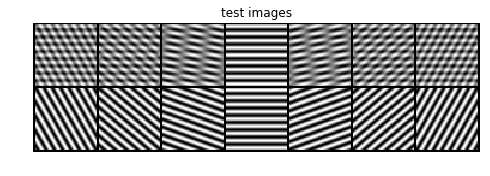

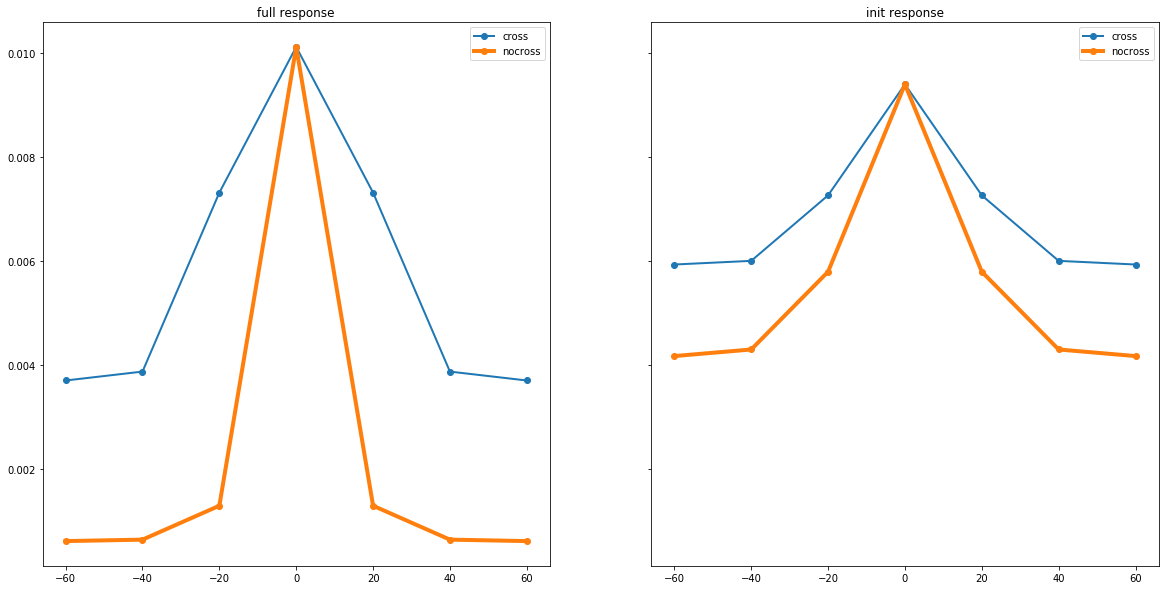

In [7]:
fig6a()

In [8]:
def fig6bc():
    crop=0;
    grating_wavel=6
    patch_diam=51
    iterations=20
    contrasts=np.array([0,0.06,0.12,0.25,0.50])
    phase=0

    mask_angle=90

    im_all = []
    response_all = []
    response_all_init = []
    for i, contg in enumerate(contrasts):
        response_this_contrast = []
        response_this_contrast_init = []
        for j, contm in enumerate(contrasts):
            im_this=io.image_cross_orientation_sine(patch_diam,grating_wavel,grating_wavel,
                                                    0,mask_angle,phase,phase,contg,contm)
            im_all.append(im_this.copy())
            im_on, im_off = io.preprocess_image(im_this)
            y_init = core.dim_conv(w_ff_on, w_ff_off, im_on, im_off, iterations=1, verbose=False)
            y_full = core.dim_conv(w_ff_on, w_ff_off, im_on, im_off, iterations=iterations, verbose=False)
            assert y_full.shape == (iterations, 32, patch_diam, patch_diam)
            assert y_init.shape == (1, 32, patch_diam, patch_diam)
            response_this_contrast.append(y_full[:,0,patch_diam//2,patch_diam//2].mean())
            response_this_contrast_init.append(y_init[0,0,patch_diam//2,patch_diam//2])
        response_all.append(response_this_contrast)
        response_all_init.append(response_this_contrast_init)
    
    imshow_pytorch(make_grid(FloatTensor(np.asarray(im_all)[:,np.newaxis]),
                             nrow=len(contrasts), normalize=False),
                  title='test images')
    
    
    # plot 6b.
    contrast_names = ['{:.2f}'.format(x) for x in contrasts]
    x_axis = contrasts + 0.012
    plt.close('all')
    fig, axes = plt.subplots(1,2,sharex=True, sharey=True, figsize=(20,10))
    plot_groups_of_lines(x_axis, np.asarray(response_all).T,
                         contrast_names, 'o', ax=axes[0], xlog=True)
    axes[0].set_title('full response')
    plot_groups_of_lines(x_axis, np.asarray(response_all_init).T,
                         contrast_names, 'o', ax=axes[1], xlog=True)
    axes[1].set_title('init response')
    fig.suptitle('6b')
    
    plt.show()
    
    
    
    # plot 6c
    plt.close('all')
    fig, axes = plt.subplots(1,2,sharex=True, sharey=True, figsize=(20,10))
    plot_groups_of_lines(x_axis, np.asarray(response_all),
                         contrast_names, 'o', ax=axes[0], xlog=True)
    axes[0].set_title('full response')
    plot_groups_of_lines(x_axis, np.asarray(response_all_init),
                         contrast_names, 'o', ax=axes[1], xlog=True)
    axes[1].set_title('init response')
    fig.suptitle('6c')
    
    plt.show()

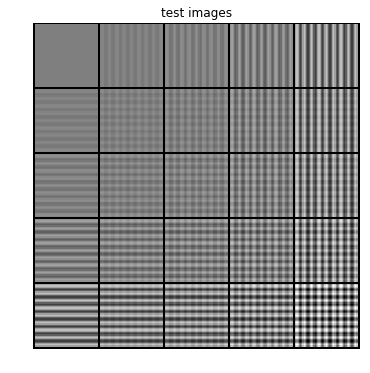

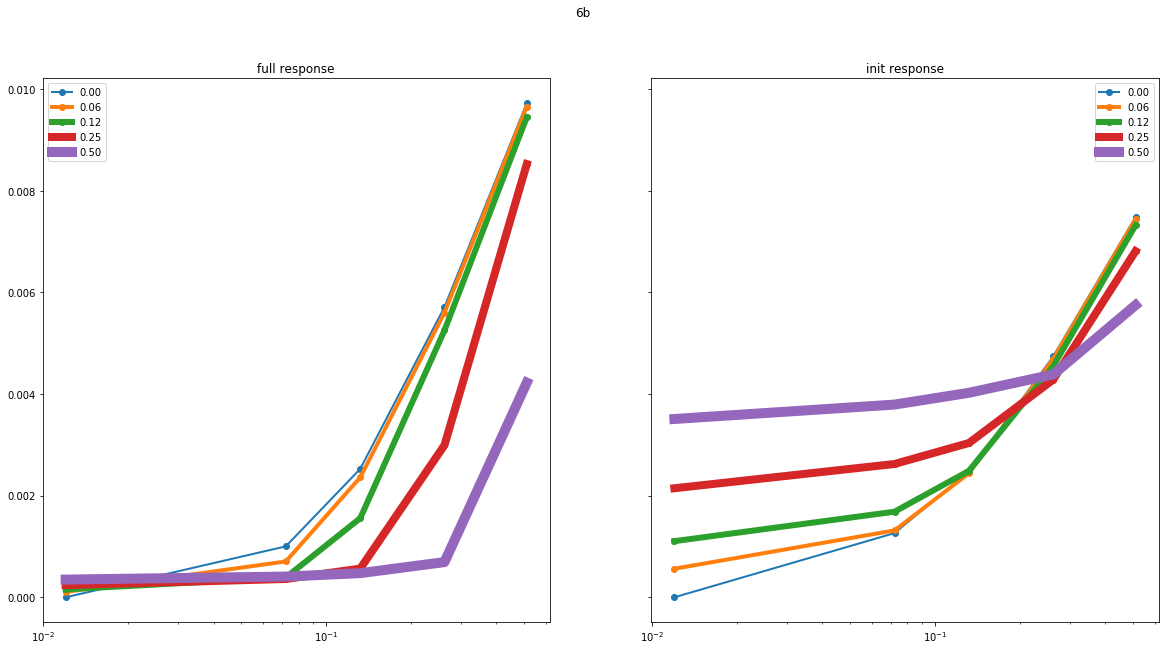

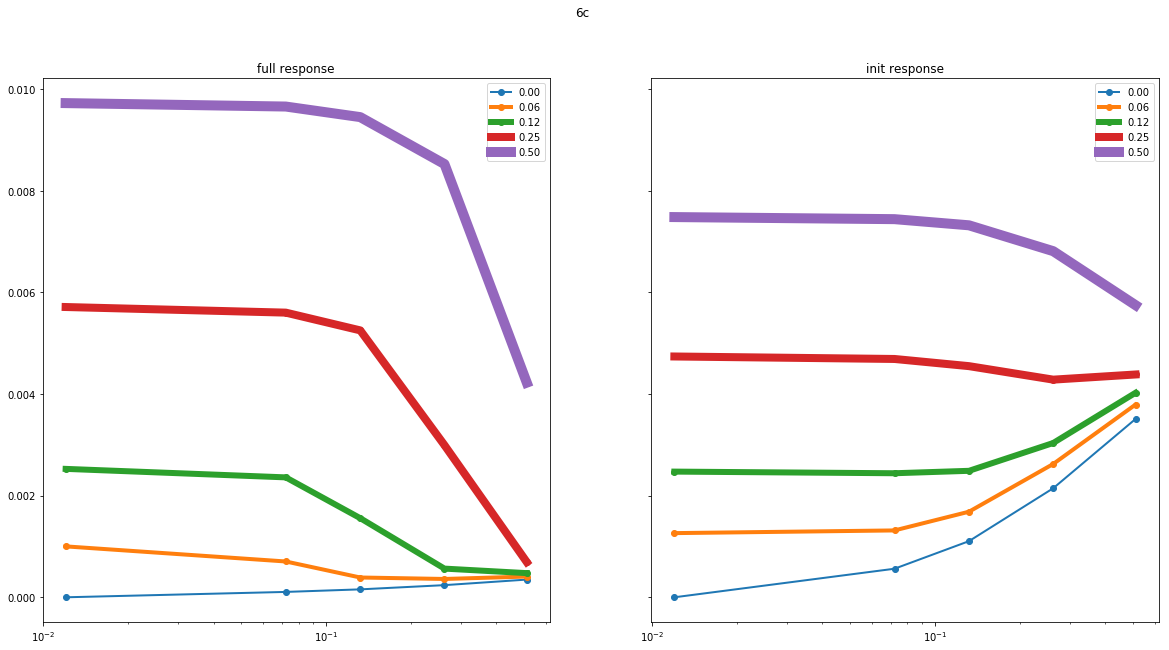

In [9]:
fig6bc()